# Compare with rouse model

In [1]:
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.rouse as rouse

In [2]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/8b2b60a0"

## Read and process the data

In [3]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data" / "initial_system.data"
PATHS_TRAJECTORIES = [
    PATH_EXPERIMENT / "data/polymer_relax.out",
    PATH_EXPERIMENT / "data/polymer.out",
]

### Read system

In [4]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system

LammpsSystemData(box=-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi, masses=   mass
1   1.0
2   1.0
3   1.0, atoms=       molecule-ID  type         x         y         z  ix  iy  iz
1                1     1  0.000000  0.000000  0.000000   0   0   0
2                1     1 -0.159927 -0.017451 -0.956566   0   0   0
3                1     2 -0.086992 -0.765936 -0.343908   0   0   0
4                1     2  0.059319  0.029401 -0.879569   0   0   0
5                1     2  0.514538  0.823298 -0.558005   0   0   0
...            ...   ...       ...       ...       ...  ..  ..  ..
31996          500     2 -0.155401 -2.419676 -5.478630   0   0   0
31997          500     2  0.094138 -2.563573 -4.552388   0   0   0
31998          500     2 -0.319976 -2.430868 -3.685325   0   0   0
31999          500     2  0.280073 -3.192872 -3.671499   0   0   0
32000          500     3  0.498631 -4.134986 -3.596971   0   0   0

[32000 rows x 8 columns], angle

### Read and process trajectories

In [5]:
PATH_TRAJECTORY_PROCESSED = PATH_EXPERIMENT / "data" / "processed" / "trajectory_unfolded.csv"
PATH_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-free-angle/3-FENE-beadspring-free-angle/8b2b60a0/data/processed/trajectory_unfolded.csv')

In [6]:
df_trajectory_unfolded = pd.read_csv(PATH_TRAJECTORY_PROCESSED)
df_trajectory_unfolded

,t,id,type,x,y,z,ix,iy,iz,molecule-ID
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1
1,0,2,1,-0.159927,-0.017451,-0.956566,0,0,0,1
2,0,3,2,-0.086992,-0.765936,-0.343908,0,0,0,1
3,0,4,2,0.059319,0.029401,-0.879569,0,0,0,1
4,0,5,2,0.514538,0.823298,-0.558005,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
32063995,10000000,31996,2,-4.857580,-0.754923,-0.722281,0,0,0,500
32063996,10000000,31997,2,-4.764690,-0.676653,-1.687060,0,0,0,500
32063997,10000000,31998,2,-4.680360,-1.146870,-0.841531,0,0,0,500
32063998,10000000,31999,2,-4.878240,-0.628830,-1.618650,0,0,0,500


### Read and process ETE

In [7]:
df_ete = pd.read_csv(PATH_ETE, index_col=["molecule-ID", "t"])
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x      R_y       R_z         R     t/LJ  \
molecule-ID t                                                          
1           0         5.307310 -4.65918  5.742710  9.102429      0.0   
            10000     4.477460 -2.62142  2.985820  5.986202     25.0   
            20000     3.877650 -5.31453  3.003340  7.231905     50.0   
            30000     4.671750 -5.92066  0.420909  7.553584     75.0   
            40000     3.542370 -3.03872 -0.088329  4.667977    100.0   
...                        ...      ...       ...       ...      ...   
500         9960000  -4.325340 -1.80387  1.087830  4.811017  24900.0   
            9970000  -0.542188 -1.56582  4.592320  4.882127  24925.0   
            9980000  -1.514490 -1.18435  2.809650  3.404482  24950.0   
            9990000  -1.668950 -2.35884 -1.988550  3.507685  24975.0   
            10000000 -5.049460 -1.11121 -2.458990  5.725248  25000.0   

                            R^2  
molecule-ID t                    
1           0         82.854216  
            10000     35.834612  
            20000     52.300450  
            30000     57.056627  
            40000     21.790006  
...                         ...  
500         9960000   23.145887  
            9970000   23.835163  
            9980000   11.590498  
            9990000   12.303851  
            10000000  32.778466  

[500500 rows x 6 columns]

In [8]:
df_ete_mean = df_ete.groupby("t/LJ")[["R", "R^2"]].mean()
df_ete_mean

,R,R^2
t/LJ,,
0.0,7.194672,61.033399
25.0,7.255560,62.041727
50.0,7.143499,60.652732
75.0,7.224358,61.922616
100.0,7.127063,59.837526
...,...,...
24900.0,7.231257,61.719521
24925.0,7.073523,58.792434
24950.0,7.043462,58.421856


In [9]:
df_ete_change_mean = pd.DataFrame(transform.calculate_ete_change_ens_avg_df(df_ete), columns=["dR"])
df_ete_change_mean["t/LJ"] = df_ete_change_mean.index.map(lambda x: x * 0.0025)
df_ete_change_mean

,dR,t/LJ
t,,
0,0.000000,0.0
10000,17.029808,25.0
20000,25.144421,50.0
30000,32.767199,75.0
40000,37.212036,100.0
...,...,...
9960000,114.962732,24900.0
9970000,114.375574,24925.0
9980000,115.186804,24950.0


## Get the constants

### Number of bonds

In [10]:
N_bonds = len(system.bonds) / len(system.atoms["molecule-ID"].unique())
assert N_bonds.is_integer()
N_bonds = int(N_bonds)
N_bonds

63

In [11]:
N_bonds_rouse = N_bonds + 1
N_bonds_rouse

64

### Bond size

Calculate average bond size neglecting the variations: $l_b^2 = \langle \langle (r_k - r_{k-1})^2 \rangle  \rangle_t$ as average over ensemble averaged over time

In [12]:
l_df = df_trajectory_unfolded.groupby("t").apply(transform.calculate_neigh_distance_avg_df, t_equilibrium=0)
l_df

/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


t
0                NaN
10000       0.942298
20000       0.942899
30000       0.942261
40000       0.942304
              ...   
9960000     0.942214
9970000     0.942716
9980000     0.942392
9990000     0.942528
10000000    0.942393
Length: 1001, dtype: float64

In [13]:
l_df.describe()

count    1000.000000
mean        0.942254
std         0.000364
min         0.941203
25%         0.942011
50%         0.942243
75%         0.942513
max         0.943426
dtype: float64

In [14]:
l_b = .97
l_b

0.97

In [15]:
L_contour = l_b * N_bonds
L_contour

61.11

### Rouse time estimated analytically

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta N_b^2 l_b^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_b^2} $$

In [16]:
zeta = 1  # LJ
k_B = 1
T = 1
tau_rouse = rouse.rouse_relaxation_time(N_bonds_rouse, l_b, zeta, T, k_B)
tau_rouse

130.16146150615123

## Plot simulation data and rouse predicted

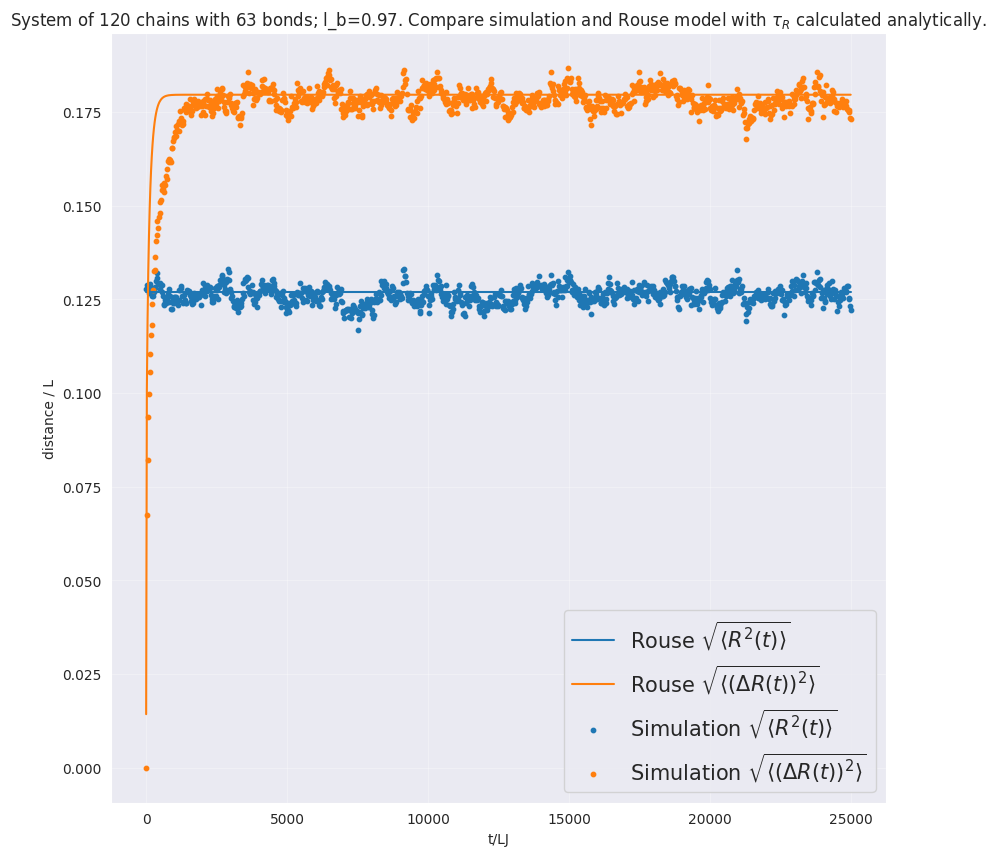

In [18]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_R_sq_avg(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b)
    ) / L_contour,
    label=r"Rouse $ \sqrt{ \langle R^2(t) \rangle } $"
)
ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(
        t=df_ete_mean.index,
        N_b=N_bonds_rouse,
        l_b=l_b,
        tau_R=tau_rouse,
        p_max=int(N_bonds_rouse))
    ) / L_contour,
    label=r"Rouse $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $"
)
ax.scatter(
    df_ete_mean.index,
    np.sqrt(df_ete_mean["R^2"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle R^2(t) \rangle } $",
    s=10
)
ax.scatter(
    df_ete_change_mean["t/LJ"],
    np.sqrt(df_ete_change_mean["dR"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $",
    s=10
)
ax.set_xlabel("t/LJ")
ax.set_ylabel("distance / L")
ax.set_title(f"System of 120 chains with {N_bonds} bonds; l_b={l_b:.2f}. Compare simulation and Rouse model with $\\tau_R$ calculated analytically.")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=15)

## Estimate rouse time from the fit and compare

In [19]:
from functools import partial

popt, pcov = scipy.optimize.curve_fit(
    partial(rouse.rouse_g_4, p_max=N_bonds_rouse, N_b=N_bonds_rouse, l_b=l_b),
    xdata=df_ete_change_mean["t/LJ"],
    ydata=df_ete_change_mean["dR"],
    p0=tau_rouse,
)
popt, pcov

(array([526.7289699]), array([[77.30739048]]))

In [20]:
t_rouse_fit = popt[0]
dt_rouse_fit = np.sqrt(np.diag(pcov))[0]
print(f"Estimated rouse time (+- 1std err) = {t_rouse_fit} +- {dt_rouse_fit}")

Estimated rouse time (+- 1std err) = 526.7289698980491 +- 8.792462139959744


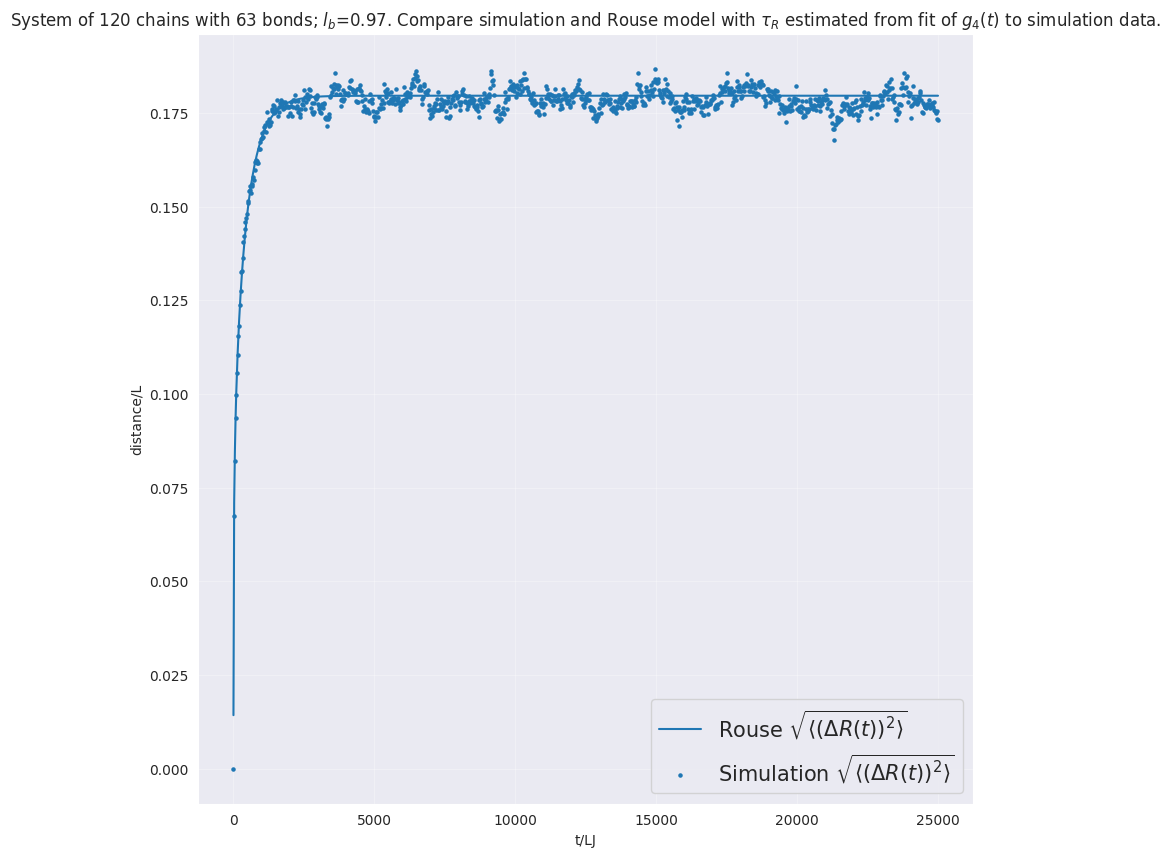

In [21]:
ax: plt.Axes
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    df_ete_mean.index,
    np.sqrt(rouse.rouse_g_4(df_ete_mean.index, N_b=N_bonds_rouse, l_b=l_b, tau_R=t_rouse_fit, p_max=int(N_bonds_rouse))) / L_contour,
    label=r"Rouse $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $"
)
ax.scatter(
    df_ete_change_mean["t/LJ"],
    np.sqrt(df_ete_change_mean["dR"]) / L_contour,
    label=r"Simulation $ \sqrt{ \langle (\Delta R(t))^2 \rangle } $",
    s=5
)
ax.set_xlabel("t/LJ")
ax.set_ylabel("distance/L")
ax.set_title(f"System of 120 chains with {N_bonds} bonds; $l_b$={l_b:.2f}. Compare simulation and Rouse model with $\\tau_R$ estimated from fit of $g_4(t)$ to simulation data.")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=15)

### Relaxation time of single bead $\tau_0$

In [22]:
tau_0_theory = rouse.relaxation_time_bead(tau_rouse, N_bonds_rouse)
tau_0_empirical = rouse.relaxation_time_bead(t_rouse_fit, N_bonds_rouse)
d_tau_0_empirical = rouse.relaxation_time_bead(dt_rouse_fit, N_bonds_rouse)

print(f"Empirical: tau_0~={tau_0_empirical:.3f}+-{d_tau_0_empirical:.3f}")
print(f"Theory: tau_0~={tau_0_theory:.3f}")

Empirical: tau_0~=3.808+-0.064
Theory: tau_0~=0.941


### Adjustment factor $\alpha$
$ \alpha = \frac{\tau_{0, \textrm{empirical}}}{\tau_{0, analytical}} $

In [24]:
adjustment_factor_alpha = tau_0_empirical / tau_0_theory
print(f"Estimated Adjustment factor: {adjustment_factor_alpha}")

Estimated Adjustment factor: 4.046735214886602
